<a href="https://colab.research.google.com/github/iamTANMOY7/Mango-Leaf-Disease-Detection/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [3]:
!unzip "/content/drive/MyDrive/Project/MangoLeafBD Dataset.zip" -d "/content"

Archive:  /content/drive/MyDrive/Project/MangoLeafBD Dataset.zip
   creating: /content/MangoLeafBD Dataset/Anthracnose/
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: /content/MangoLeafBD Dataset/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: /content/MangoLea

In [4]:
data_dir = "/content/MangoLeafBD Dataset"
#'MangoLeafBD Dataset'

In [5]:
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
# prompt: Using dataframe df: split the data as train , valid and test in a way so that my model cant see the test data

from sklearn.model_selection import train_test_split

# Split the data into train and test sets, with 20% of the data in the test set
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Split the train data into train and validation sets, with 20% of the data in the validation set
train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42, shuffle=True)

In [7]:
# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 2240 validated image filenames belonging to 8 classes.
Found 960 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


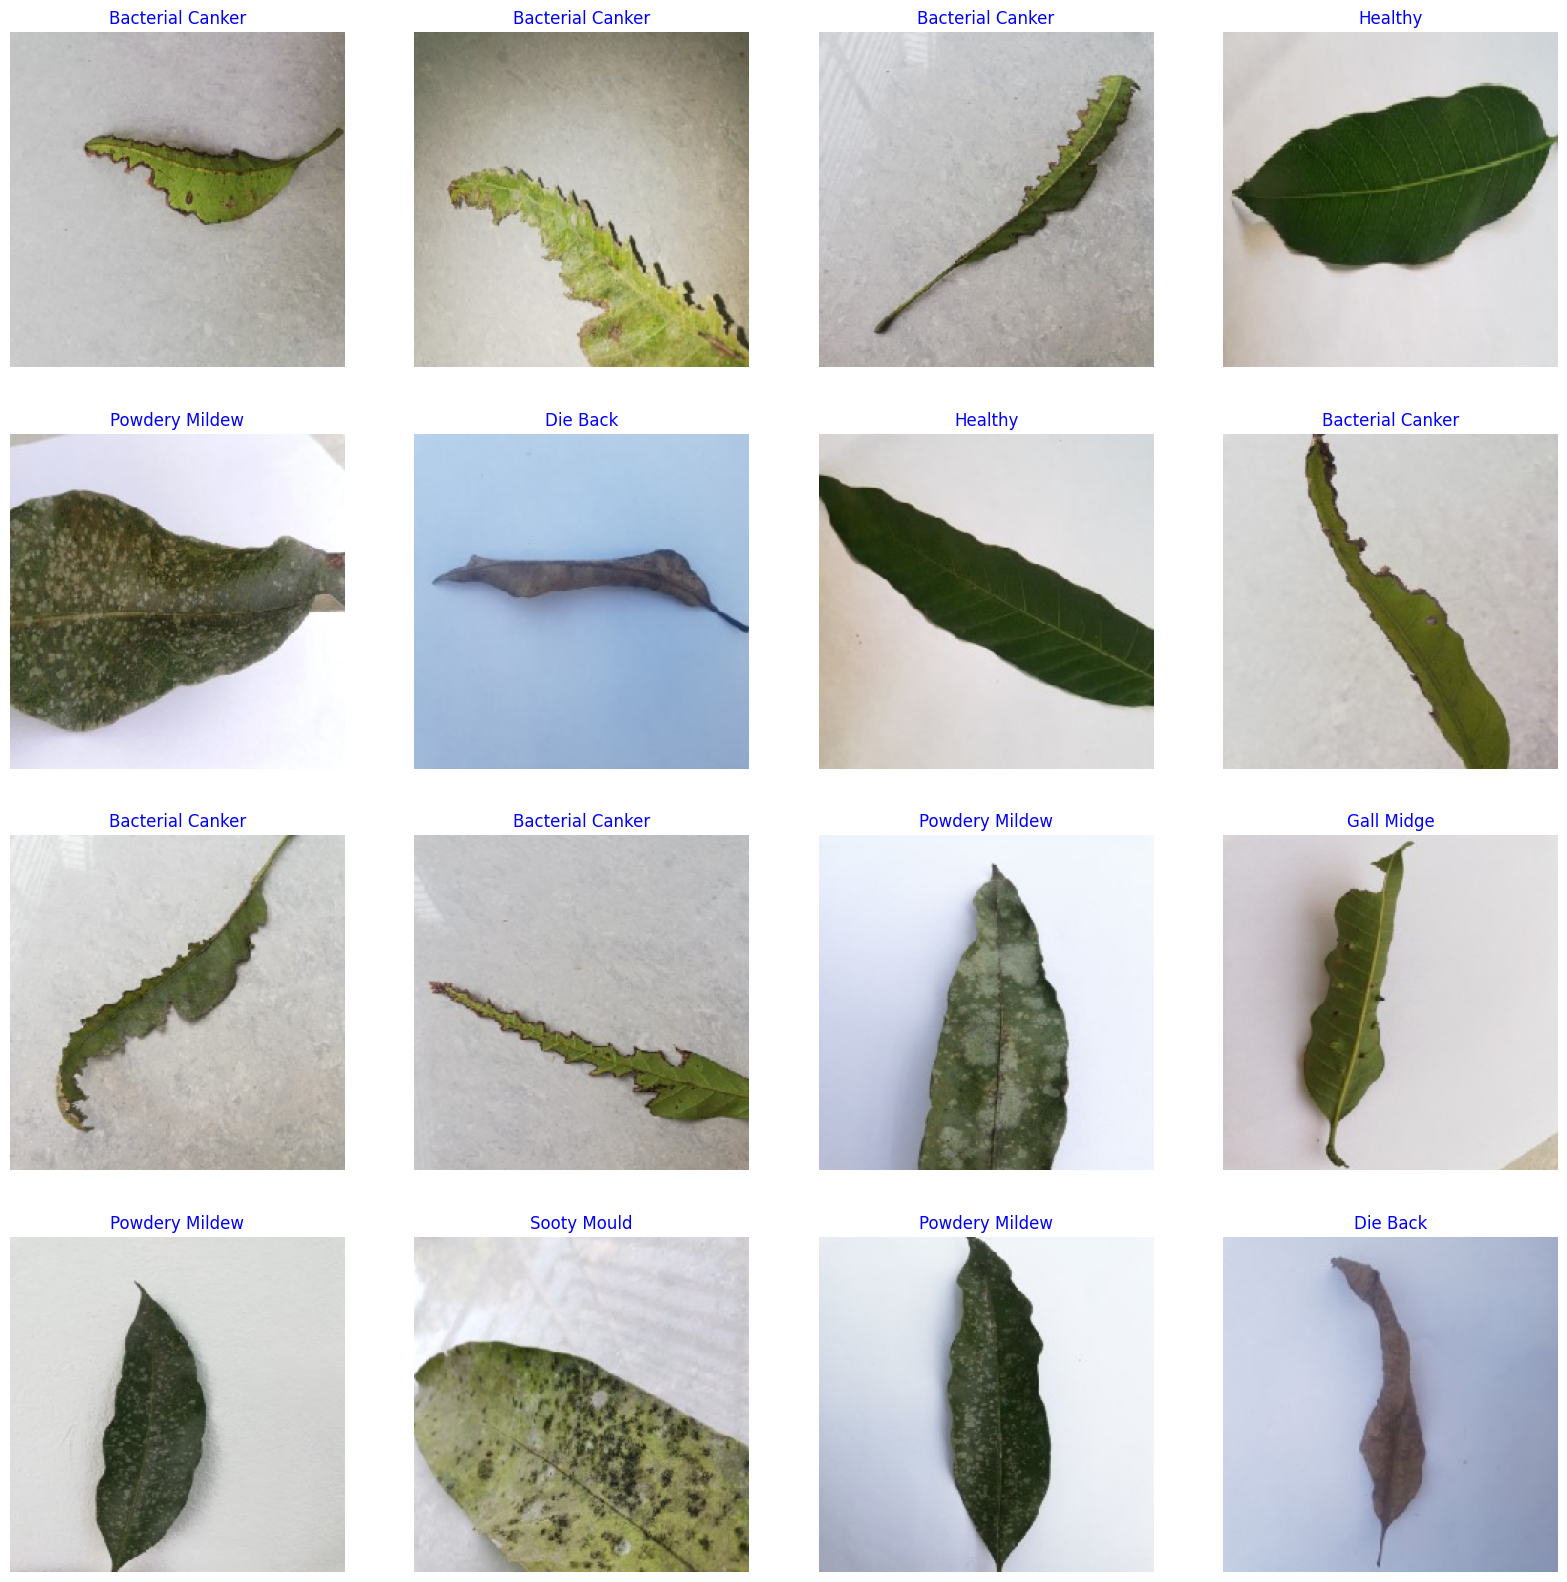

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model =base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.20, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 14850120 (56.65 MB)
Trainable params: 13440

In [10]:
batch_size = 32 # set batch size for training
epochs = 50  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)
model.save('/content/drive/MyDrive/mangomodelvgg16.keras')

Epoch 1/50
70/70 [==============================] - 26s 200ms/step - loss: 6.2558 - accuracy: 0.7826 - val_loss: 5.6320 - val_accuracy: 0.9062
Epoch 2/50
70/70 [==============================] - 14s 196ms/step - loss: 4.7410 - accuracy: 0.9527 - val_loss: 4.3166 - val_accuracy: 0.9521
Epoch 3/50
70/70 [==============================] - 12s 176ms/step - loss: 3.8063 - accuracy: 0.9705 - val_loss: 3.4395 - val_accuracy: 0.9625
Epoch 4/50
70/70 [==============================] - 13s 181ms/step - loss: 3.0486 - accuracy: 0.9857 - val_loss: 2.7619 - val_accuracy: 0.9656
Epoch 5/50
70/70 [==============================] - 13s 186ms/step - loss: 2.4459 - accuracy: 0.9893 - val_loss: 2.2233 - val_accuracy: 0.9688
Epoch 6/50
70/70 [==============================] - 13s 191ms/step - loss: 1.9608 - accuracy: 0.9920 - val_loss: 1.7916 - val_accuracy: 0.9740
Epoch 7/50
70/70 [==============================] - 14s 197ms/step - loss: 1.5766 - accuracy: 0.9924 - val_loss: 1.4527 - val_accuracy: 0.9781

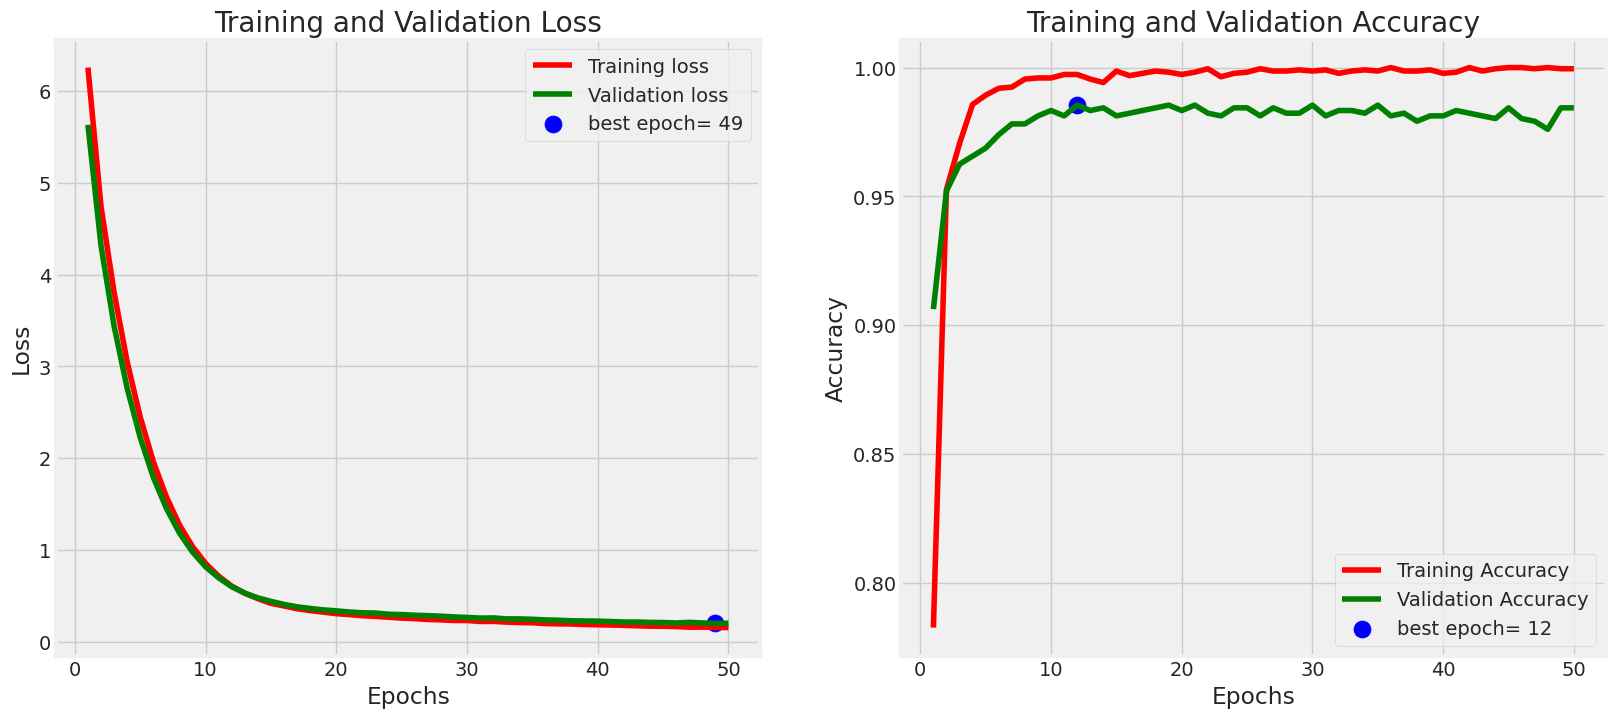

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 18s 348ms/step - loss: 0.1713 - accuracy: 0.9887
Train Loss:  0.13728860020637512
Train Accuracy:  1.0
--------------------
Validation Loss:  0.1916137933731079
Validation Accuracy:  0.9937499761581421
--------------------
Test Loss:  0.1712942123413086
Test Accuracy:  0.9887499809265137


In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

10/10 [==============================] - 4s 342ms/step


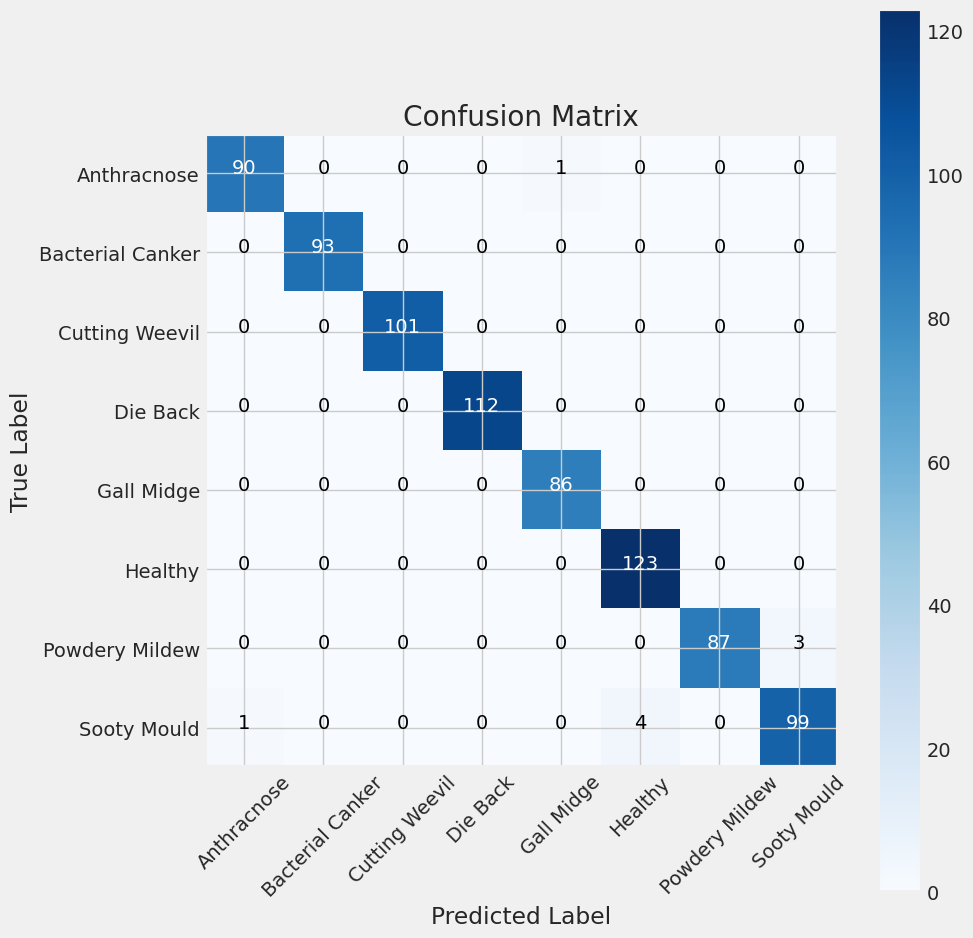

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       0.99      0.99      0.99        91
Bacterial Canker       1.00      1.00      1.00        93
  Cutting Weevil       1.00      1.00      1.00       101
        Die Back       1.00      1.00      1.00       112
      Gall Midge       0.99      1.00      0.99        86
         Healthy       0.97      1.00      0.98       123
  Powdery Mildew       1.00      0.97      0.98        90
     Sooty Mould       0.97      0.95      0.96       104

        accuracy                           0.99       800
       macro avg       0.99      0.99      0.99       800
    weighted avg       0.99      0.99      0.99       800



In [37]:
# prompt: generate code that will take a single image and predict it using my saved model
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# Load the saved model
model = keras.models.load_model('/content/drive/MyDrive/mangomodelvgg16.keras')

# Load the image
image_path = '/content/drive/MyDrive/Mango Leaf 2.png'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
print(input_arr.shape)

(1, 224, 224, 3)


In [38]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
model = keras.models.load_model('/content/drive/MyDrive/mangomodelvgg16.keras')
prediction = model.predict(input_arr)
prediction.shape

1/1 [==============================] - 0s 240ms/step


(1, 8)

In [39]:
result_index = np.argmax(prediction)
result_index

7

In [40]:
# prompt: make a list of the class names

class_names = ['Anthracnose',
               'Bacterial Canker',
               'Cutting Weevil',
               'Die Back',
               'Gall Midge',
               'Healthy',
               'Powdery Mildew',
               'Scooty Mould',]

In [41]:
model_predicton =  class_names[result_index]


In [42]:
model_predicton

'Scooty Mould'

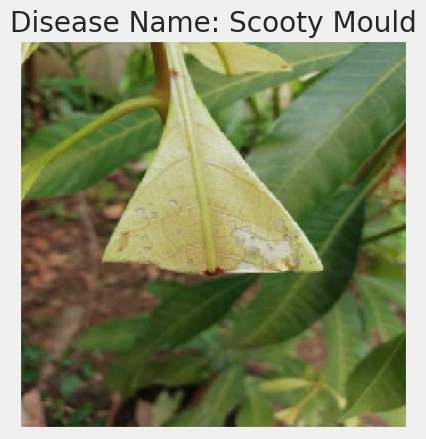

In [43]:
model_prediction=class_names[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()